In [1]:
# https://www.geeksforgeeks.org/python-how-to-make-a-terminal-progress-bar-using-tqdm/#:~:text=Usage,would%20not%20work%20at%20all.
# https://www.geeksforgeeks.org/saving-a-video-using-opencv/
# https://stackoverflow.com/questions/34588464/python-how-to-capture-image-from-webcam-on-click-using-opencv -> vou usar isso para salvar o frame quando finalizar o vídeo

# https://stackoverflow.com/questions/11541154/checking-images-for-similarity-with-opencv -> link para desenhar bound boxes nas imagens

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm


def create_video_capture(input_dir: str = "VideoEntrada/", video_name_input: str = "input.mp4", frames: float = 30.0,
                         save_dir: str = "Resultados/VideoIterativo/", file_to_save: str = "ImagemMono.mp4",
                         **kwargs) -> tuple[dict[int, np.ndarray], dict[int, np.ndarray]]:
    if "k_size" in kwargs.keys():
        k_size = kwargs.pop("k_size")

    else:
        k_size = (5, 5)

    if "sigma_x" in kwargs.keys():
        sigma_x = kwargs.pop("sigma_x")

    else:
        sigma_x = 0.0

    if "sigma_y" in kwargs.keys():
        sigma_y = kwargs.pop("sigma_y")

    else:
        sigma_y = 0.0

    if "kernel_di" in kwargs.keys():
        kernel_di = kwargs.pop("kernel_di")

    else:
        kernel_di = (5, 5)

    if "n_iterations_di" in kwargs.keys():
        n_iterations_di = kwargs.pop("n_iterations_di")

    else:
        n_iterations_di = 1

    if "t_min" in kwargs.keys():
        t_min = kwargs.pop("t_min")

    else:
        t_min = 127

    if "t_max" in kwargs.keys():
        t_max = kwargs.pop("t_max")

    else:
        t_max = 255

    kernel_vec = np.ones(kernel_di, dtype=np.uint8)

    # Create an object to read
    # from camera
    video = cv2.VideoCapture(0)

    i = 0
    video_frames_original = {}
    video_frames_output = {}

    # We need to check if camera
    # is opened previously or not
    if (video.isOpened() == False):
        print("Error reading video file")

    # We need to set resolutions.
    # so, convert them from float to integer.
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))

    size = (frame_width, frame_height)

    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(save_dir, exist_ok=True)

    # Below VideoWriter object will create
    # a frame of above defined The output
    # is stored in 'filename.avi' file.
    video_reader_input = cv2.VideoWriter("{}/{}".format(input_dir, video_name_input),
                                         cv2.VideoWriter_fourcc(*'mp4v'),
                                         frames, size)

    video_reader_gray = cv2.VideoWriter("{}/{}".format(save_dir, file_to_save),
                                        cv2.VideoWriter_fourcc(*'mp4v'),
                                        frames, size)

    while (True):
        ret, frame = video.read()

        if ret == True:

            # Write the frame into the
            # file 'filename.avi'
            video_reader_input.write(frame)
            video_frames_original[i] = frame[:, :, ::-1].copy()

            # Realizando os processos de pré-processamento desejado
            # https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html -> Esse é o link de referência utilizado
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.GaussianBlur(frame, k_size, sigma_x, sigma_y)
            #frame = cv2.adaptiveThreshold(frame, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
            _, frame = cv2.threshold(frame, t_min, t_max, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            frame = cv2.dilate(frame, kernel_vec, iterations=n_iterations_di)
            contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            frame = _draw_bd(contours, frame)

            video_reader_gray.write(frame)
            video_frames_output[i] = frame

            i += 1

            # Display the frame
            # saved in the file
            cv2.imshow('Frame', frame)

            # Press Q on keyboard
            # to stop the process
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

        # Break the loop
        else:
            break

    # When everything done, release
    # the video capture and video
    # write objects
    video.release()
    video_reader_input.release()
    video_reader_gray.release()

    # Closes all the frames
    cv2.destroyAllWindows()

    print("The video was successfully saved")
    return video_frames_original, video_frames_output


def _draw_bd(contorn_coords, frame_img: np.ndarray, area_threshold: int = 100) -> np.ndarray:
    new_frame_img = np.zeros(shape=(frame_img.shape[0], frame_img.shape[1], 3), dtype=frame_img.dtype)
    new_frame_img[:, :, 0] = frame_img
    new_frame_img[:, :, 1] = frame_img
    new_frame_img[:, :, 2] = frame_img

    for c in contorn_coords:
        area = cv2.contourArea(c)
        if area > area_threshold:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(new_frame_img, (x, y), (x + w, y + h), (36, 255, 12), 2)

    return new_frame_img

In [2]:
dict_val, dict_val_out = create_video_capture(sigma_x=0.5, sigma_y=0.7, frames=30.0)

QObject::moveToThread: Current thread (0x55f5506d4160) is not the object's thread (0x55f5512c9340).
Cannot move to target thread (0x55f5506d4160)

QObject::moveToThread: Current thread (0x55f5506d4160) is not the object's thread (0x55f5512c9340).
Cannot move to target thread (0x55f5506d4160)

QObject::moveToThread: Current thread (0x55f5506d4160) is not the object's thread (0x55f5512c9340).
Cannot move to target thread (0x55f5506d4160)

QObject::moveToThread: Current thread (0x55f5506d4160) is not the object's thread (0x55f5512c9340).
Cannot move to target thread (0x55f5506d4160)

QObject::moveToThread: Current thread (0x55f5506d4160) is not the object's thread (0x55f5512c9340).
Cannot move to target thread (0x55f5506d4160)

QObject::moveToThread: Current thread (0x55f5506d4160) is not the object's thread (0x55f5512c9340).
Cannot move to target thread (0x55f5506d4160)

QObject::moveToThread: Current thread (0x55f5506d4160) is not the object's thread (0x55f5512c9340).
Cannot move to tar

The video was successfully saved


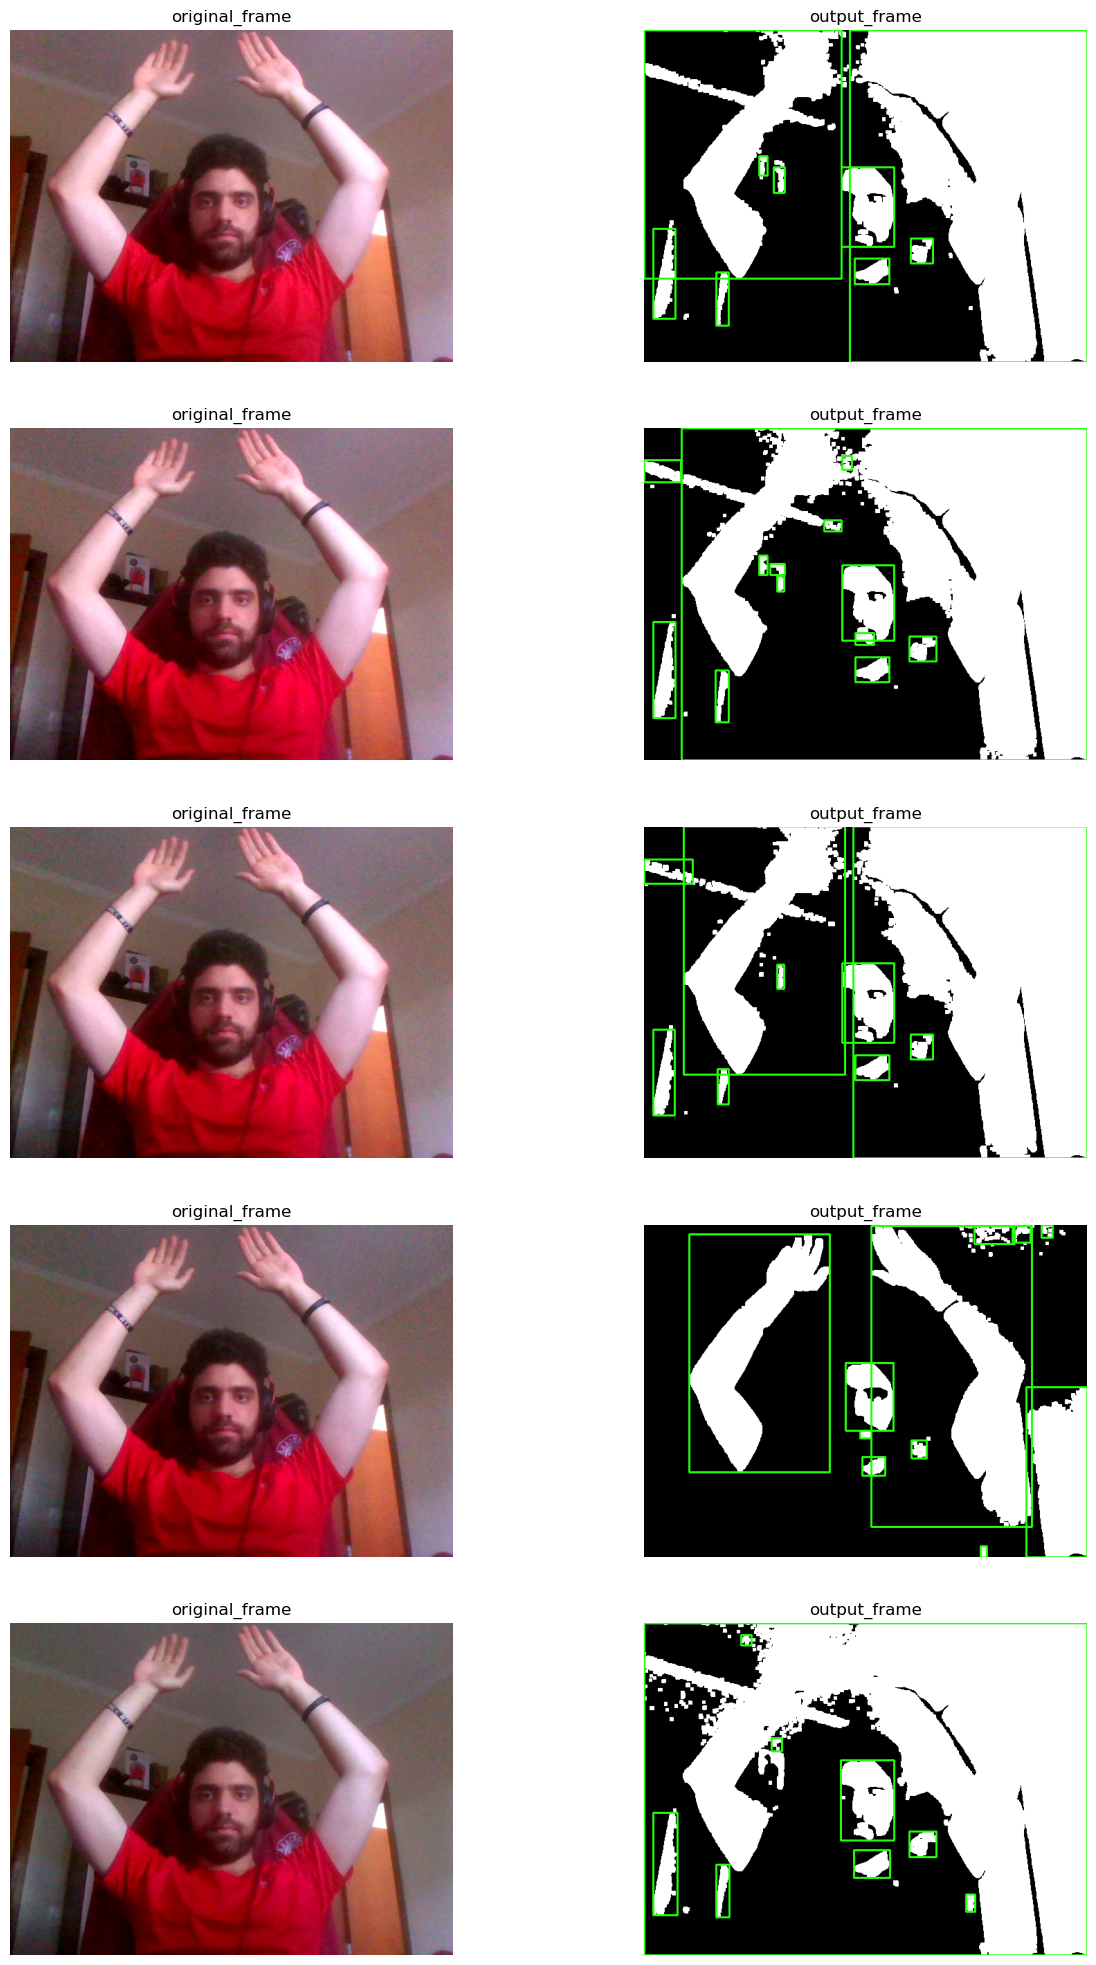

In [3]:
# https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
# https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/
_, axe = plt.subplots(5, 2, figsize=(15, 25))

for ax, original_frame, out_frame in zip(axe, dict_val.values(), dict_val_out.values()):
    ax[0].imshow(original_frame, vmin=original_frame.min(), vmax=original_frame.max())
    ax[0].set_title("original_frame")
    ax[0].axis("off")

    ax[1].imshow(out_frame, vmin=out_frame.min(), vmax=out_frame.max())
    ax[1].set_title("output_frame")
    ax[1].axis("off")

plt.show()

In [4]:
from ipywidgets import Video

Video.from_file("VideoEntrada/input.mp4", width=480, height=640)

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00$\x90\x83mdat\x00\x0…